# Distributed Hybrid Plant - Residential Example

This example focuses on distributed-scale energy—energy that is connected at the distribution level of the electrical grid or off-grid. Distributed energy can supply on-site electricity demand and improve energy reliability and resilience for residential, commercial, and agricultural end-users. This particular example considers a small mountain town in south-central Colorado.

## Available Resources for Distributed Energy

This example highlights various resources for distributed energy modeling:

- **Wind Turbine Models**: Users can find available turbines for distributed applications in the [turbine-models repository](https://github.com/NREL/turbine-models).
- **Load Profile Data**: The [ResStock Dataset](https://www2.nrel.gov/buildings/end-use-load-profiles) provides estimated end-use load profiles for residential buildings.
- **Annual Technology Baseline (ATB)**: This resource offers transparent, normalized technology cost and performance assumptions for various technology classes. Relevant sections include:
  - [Distributed Wind](https://atb.nrel.gov/electricity/2024/distributed_wind)
  - [Residential PV](https://atb.nrel.gov/electricity/2024/residential_pv)
  - [Residential Battery Storage](https://atb.nrel.gov/electricity/2024/residential_battery_storage)
- **ATB Data Workbooks**: The ATB Excel Workbooks contain detailed data and calculations for each technology. These workbooks can be accessed [here](https://atb.nrel.gov/electricity/2024/data).

This notebook will guide you through setting up a simulation for a distributed residential hybrid energy system using HOPP. The example includes simulates a system that includes residential rooftop solar PV, distributed wind turbines, and a lithium-ion battery storage system.

### Import required modules

Start by importing the necessary modules and packaged and setting up our working environment.

In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from floris import TimeSeries
from floris.layout_visualization import plot_turbine_points
from hopp import ROOT_DIR
from hopp.utilities.keys import set_nrel_key_dot_env
from hopp.simulation import HoppInterface
from hopp.tools.design.wind.turbine_library_tools import load_distributed_turbine_options
from hopp.utilities.utilities import load_yaml
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

set_nrel_key_dot_env()


### Display Turbine Model Options

The turbine-models repository hosts power curves and key data for commonly used turbine models in industry and the R&D community. 

There are several classes of turbine options, including:
- [Distributed](https://github.com/NREL/turbine-models/tree/master/turbine_models/data/Distributed)
- [Onshore (utility scale)](https://github.com/NREL/turbine-models/tree/master/turbine_models/data/Onshore)
- [Offshore](https://github.com/NREL/turbine-models/tree/master/turbine_models/data/Onshore)

In HOPP, you can view all distributed turbine models available in the turbine-models repository using the `load_distributed_turbine_options()` function.

**NOTE**: Most of the turbine model names are formatted "TurbineName_RatingkW_RotorDiameter"


In [15]:
load_distributed_turbine_options()

['CF11_11kW_9.36',
 'EntegrityEW50_50kW_15',
 'EWT_DW61-1000',
 'NPS100B-24C_95kW_24.4',
 'NPS100C-21_100kW_20.7',
 'Bestwind30_27.2kW_13.1',
 'FortisMontana_3.31kW_5.04',
 'CF15_15kW_11.15',
 'XzeresSkystream3.7_2.1kW_3.7',
 'CF10(PhaseA)_10kW_11.15',
 'Jacobs31-20_12kW_9.45',
 'NPS100C-28_90kW_28',
 'BergeyExcel10_8.9kW_7',
 'PikaT701_1.5kW_3',
 'EWT_DW52-900',
 'SWIFT_1kW_2.1',
 'NPS100B-21_100kW_20.7',
 'VestasV29_225kW_29',
 'GhrepowerFD21-50_61.2kW_21.5',
 'NPS100C-28_90kW_27.6',
 'EWT_DW54-X-1000',
 '2019COE_DW20_20kW_12.4',
 'VestasV27_225kW_27',
 'EWT_DW58-1000',
 'NPS100C-24_95kW_24.4',
 'EWT_DW54-900',
 'CF20_20kW_13.1',
 'NPS100B-24_95kW_23.6',
 'BergeyExcel15_15.6kW_9.6',
 'SD6_5.2kW_5.5',
 'NPS100C-27_90kW_27.4',
 'Kestrele400nb_2.5kW_4',
 '2019COE_DW100_100kW_27.6',
 'CF11(PhaseA)_11kW_11.15',
 'NPS60C-24_60kW_24.4']

We selected the "BergeyExcel15_15.6kW_9.6" turbine from the list. This is the [Bergey Excel 15](https://www.bergey.com/products/grid-tied-turbines/excel-15/) a 15.6 kW turbine that designed to work well in low wind speeds. To use that turbine model you have to then add it to your configuration YAML for the HOPP simulation. In this example that file is `examples/inputs/08-distributed-wind-solar-residential.yaml`. Add it to the line `turbine_name`.

### Selecting a Turbine Model

For this example, we selected the [Bergey Excel 15](https://www.bergey.com/products/grid-tied-turbines/excel-15/) from the available models, listed as "BergeyExcel15_15.6kW_9.6." This 15.6 kW turbine is design for low wind speed conditions, making it well-suited for distributed applications. To use this turbine model in your HOPP simulation, you need to specify it in your configuration YAML file. 

In this example, the configuration file is `examples/inputs/08-distributed-wind-solar-residential.yaml`. To include the Bergey Excel 15 turbine, add its name under the `turbine_name` field in the YAML file.

`turbine_name: "BergeyExcel15_15.6kW_9.6"`

### Load Inputs

Load the configuration YAML file as `hopp_config`.

In [16]:
example_dir = ROOT_DIR.parent / "examples"
input_filepath = os.path.join(str(example_dir),"inputs","08-distributed-wind-solar-residential.yaml")
hopp_config = load_yaml(input_filepath)

### Key Distributed Energy Inputs in the Configuration YAML

While many inputs can be included in the configuration YAML file, this example highlights key parameters specific to distributed energy systems.

#### **Wind**
- `turbine_name`: Specifies the turbine model, allowing HOPP to extract essential turbine data, including the power curve.
- `resource_parse_method`: Defines how wind resource data is processed. When set to "weighted_average" it calculates a weighted average for multiple hub heights. This is particularly important at lower hub heights due to wind shear effects.
- `adjust_air_density_for_elevation`: When set to `True`, this parameter adjusts air density based on elevation, which can impact turbine power output. At higher elevations, lower air density reduces power generation due to atmospheric conditions.

#### **Solar PV**
- The YAML file includes a separate configuration file for solar panel system design parameters.
- `panel_tilt_angle`: Specifies the tilt angle of the solar panels for optimal energy capture.

### Example Configuration File Structure

Below is an example configuration snippet showing how different distributed energy technologies are defined in the YAML file:

```yaml
technologies:
  pv:
    panel_system_design: !include "residential_pv.yaml"
    dc_degradation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    panel_tilt_angle: 20.0
    system_capacity_kw: 900.0 # System capacity in kWdc
  wind:
    num_turbines: 56
    turbine_name: "BergeyExcel15_15.6kW_9.6"
    model_name: floris
    floris_config: !include floris_v4_template.yaml
    resource_parse_method: "weighted_average"
    store_turbine_performance_results: False
    adjust_air_density_for_elevation: True
    layout_mode: "basicgrid"
    layout_params:
      row_D_spacing: 11.5
      turbine_D_spacing: 11.5
  
  battery:
    system_capacity_kwh: 700
    system_capacity_kw: 280
    minimum_SOC: 20.0
    maximum_SOC: 100.0
    initial_SOC: 20.0
```

This configuration file defines the components of a distributed hybrid energy system, including wind, solar PV, and battery storage. Each section outlines some key parameters that influence system performance.


### Create Simulation Model
Create an instance of the `HoppInterface` class by providing it a dictionary of inputs (`hopp_config`).

In [17]:
hi = HoppInterface(hopp_config)

FLORIS is the system model...


### Simulate Hybrid Plant

Run the hybrid plant simulation. By setting `project_life` to 1, you simulate a single year of operation.

In [18]:

hi.simulate(project_life = 1)
hybrid_plant = hi.system

Simulating wind farm output in FLORIS...


### Plot the Generation Profile

Three subplots are generated, displaying results for a default period of five days with hourly time steps on the x-axis:

1. **Generation Profile**
   - The red line represents PV generation, while the blue line represents wind generation.
   - The y-axis shows power in megawatts (MW).

2. **Battery Power Flow** (Dual-Axis Plot)
   - Left y-axis: Power (MW)
   - Right y-axis: State-of-Charge (SOC) as a percentage
   - The blue dashed line represents the desired load specified in the simulation.
   - The blue and red bars indicate battery discharge and charge, respectively, at each time step.
   - The black line represents the battery's SOC.
   - The blue dotted line indicates the battery dispatch profile.

3. **Net Generation Profile** (Dual-Axis Plot)
   - Left y-axis: Power (MW)
   - Right y-axis: Grid or energy price
   - The black dashed line represents the original hybrid generation profile (including wind, PV, and battery storage).
   - The green line represents the optimized generation profile after battery dispatch.
   - The red line represents the price of energy.

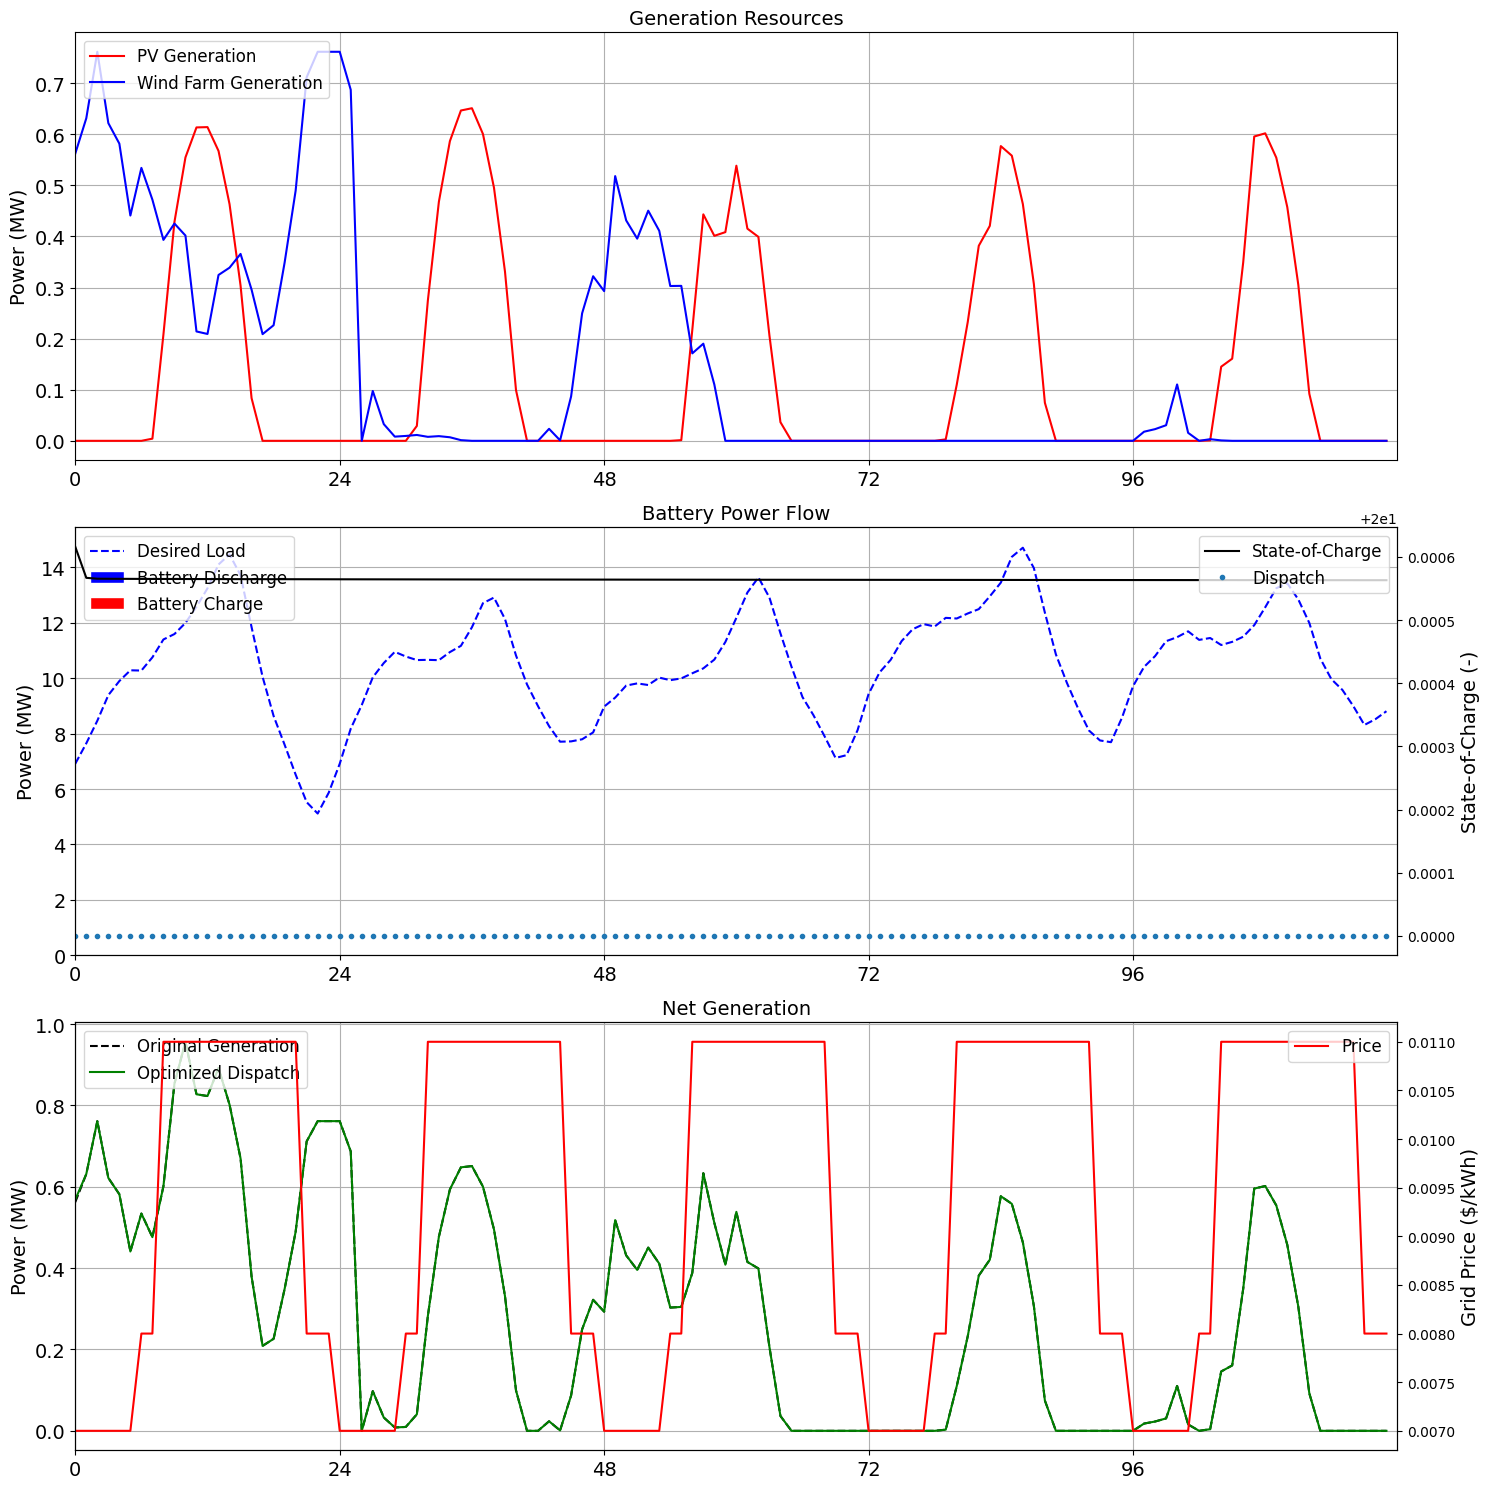

In [19]:
plot_generation_profile(hybrid_plant)

### Vizualize Wind Resource and Wind Farm Layout using FLORIS

[FLORIS](https://github.com/NREL/floris) is a wind farm wake modeling and control software. It includes a set of visualization tools that can help you analyze specific site conditions and better understand your farm layout.

### Wind Rose Plot
The wind rose plot displays wind direction and speed distributions at a given location, providing insights into the prevailing wind patterns over time. It is a valuable tool for understanding the wind resource at your site. 

<PolarAxes: >

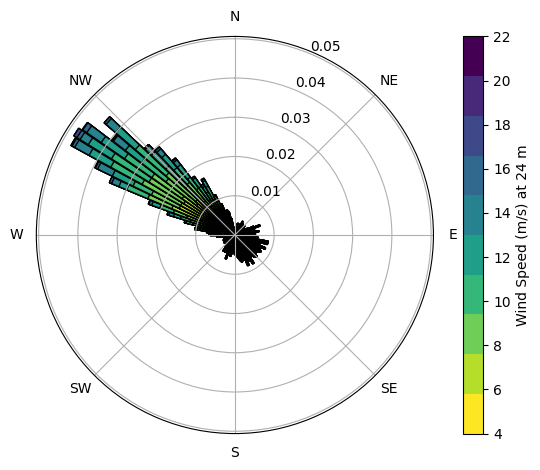

In [20]:
time_series = TimeSeries(
    wind_directions=hybrid_plant.wind._system_model.wind_dirs[0:8760],
    wind_speeds=hybrid_plant.wind._system_model.speeds[0:8760],
    turbulence_intensities=hybrid_plant.wind._system_model.fi.core.flow_field.turbulence_intensities[0]
)

wind_rose = time_series.to_WindRose(wd_edges=np.arange(0, 360, 3.0), ws_edges=np.arange(2.0, 24.0, 2.0))
fig, ax = plt.subplots(subplot_kw={"polar": True})

hub_ht = int(hybrid_plant.site.wind_resource.hub_height_meters)
wind_rose.plot(ax=ax,legend_kwargs={"label": f"Wind Speed (m/s) at {hub_ht} m"})

### Wind Farm Layout Plot
This plot shows where in space your wind turbines are located in relation to each other. The x- and y-axis are distance measured in meters.

<Axes: >

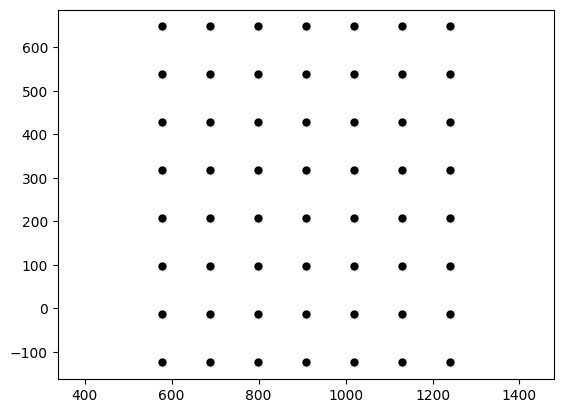

In [21]:
fig, ax = plt.subplots(1,1)
plot_turbine_points(hybrid_plant.wind._system_model.fi,ax=ax)